### Finding model parameters using Autograd to determine partial derivatives
#### This notebook is an illustration for chapter 5 of 
#### Deep Learning with PyTorch by Eli Stevens, Luca Aantiga, Thomas Viehmann, Manning 2020

In [ ]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2)

We use the same data and normilize Fahrenheit values in the same way

In [ ]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0,
                    3.0, -4.0, 6.0, 13.0, 21.0])
t_f = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])
t_fn = 0.1 * t_f

In [ ]:
def model(t_f, w, b):
    return w * t_f + b

In [ ]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

Let’s again initialize a parameters tensor. 
#### Using the grad attribute
Notice the requires_grad=True argument to the tensor constructor? That argument
is telling PyTorch to track the entire family tree of tensors resulting from operations
on params. In other words, any tensor that will have params as an ancestor will have
access to the chain of functions that were called to get from params to that tensor. In
case these functions are differentiable (and most PyTorch tensor operations will be),
the value of the derivative will be automatically populated as a grad attribute of the
params tensor.
In general, all PyTorch tensors have an attribute named grad. Normally, it’s None:

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [ ]:
params.grad is None

We determine the `loss` value for the above initial values of the parameters, perform backpropagation, by calling `backward` and read values of the partial derivatives of the `loss` with respect to `w` and `b`. Those reside in `params.grad`

In [ ]:
loss = loss_fn(model(t_f, *params), t_c)
loss.backward()

params.grad

At this point, the `grad` attribute of `params` contains the derivatives of the `loss` with
respect to each element of` param`s.
When we compute ou`r lo`ss while the parameter`s` w an`d` b require gradients, in
addition to performing the actual computation, PyTorch creates the autograd graph
with the operations (in black circles) as nodes, as shown in the top row of figbellow
5.10. When we `call loss.backw`ard(), PyTorch traverses this graph in the reverse
direction to compute the gradients, as shown by the arrows in the bottom row of
the figure.

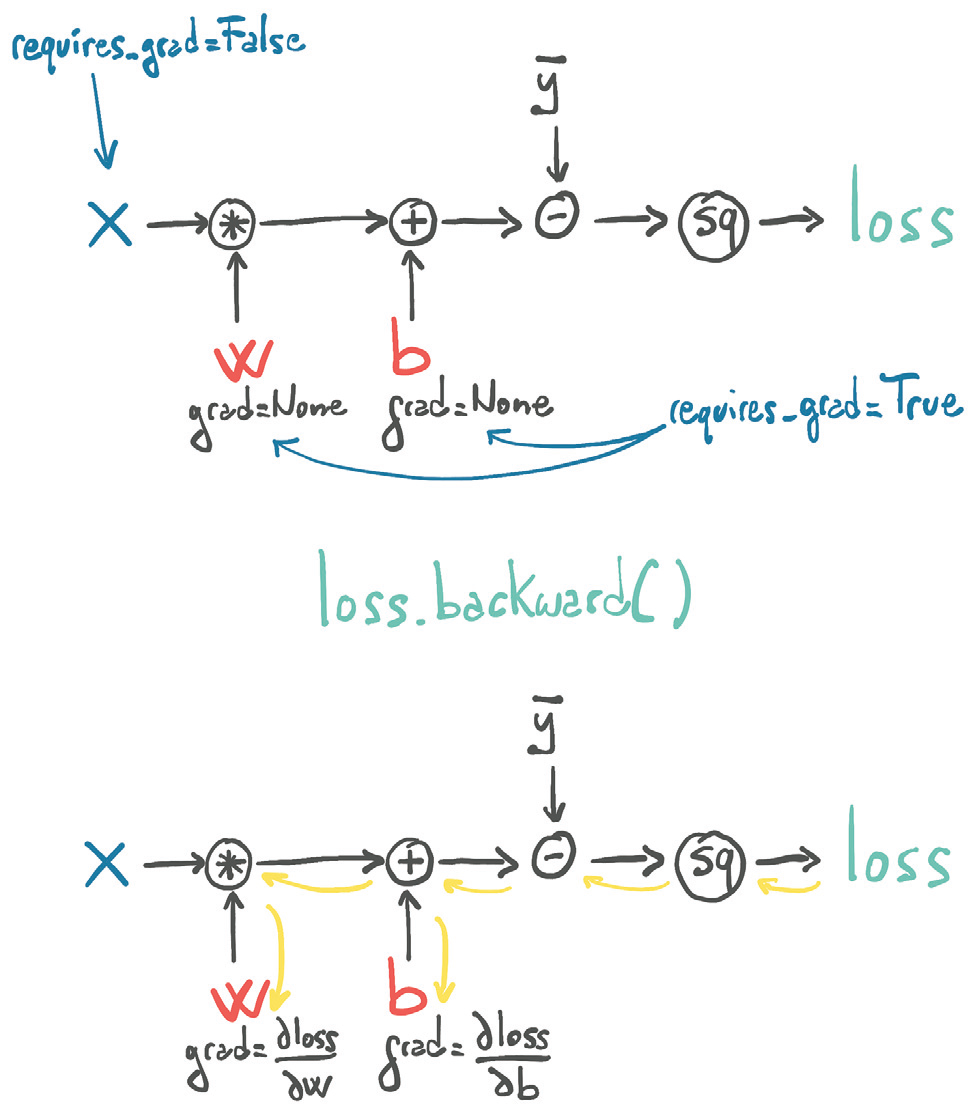

The forward graph
and backward graph of the model
as computed with autograd

In [ ]:
# grad function is accumulating and after each pass it has to be set to zero:
if params.grad is not None:
    params.grad.zero_()

### Traing loop with autograd
Our autograd-enabled
training code looks like, start to finish:

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_f, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # <1>
            # This could be done at any point in the loop prior to calling loss.backward().
            params.grad.zero_()
        
        t_p = model(t_f, *params) 
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():  # <2>
            # This is a somewhat cumbersome but can be simplified (eliminated)
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

Above, we update `params` in place. This means we keep the same `params` tensor
around but subtract our update from it. When using autograd, we usually avoid inplace
updates because PyTorch’s autograd engine might need the values we would be
modifying for the backward pass. Here, however, we are operating without autograd,
and it is beneficial to keep the params tensor. Not replacing the parameters by assigning
new tensors to their variable name will become crucial when we register our
parameters with the opt.zer in

Let us test the loop.

In [ ]:
training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    # Adding requires_grad=True is key.
    params = torch.tensor([1.0, 0.0], requires_grad=True), 
    # Again, we’re using the normalized t_fn instead of t_f.
    t_f = t_fn, # <2> 
    t_c = t_c)

The result is the same as we got previously. It means that dderivativs, no longer need to be computed by hand.